In [35]:
%reload_ext autoreload
%autoreload 2
import random
import numpy as np
import torch
seed = 42


random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from scipy.stats import norm, multivariate_normal, gaussian_kde
from scipy.integrate import nquad
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


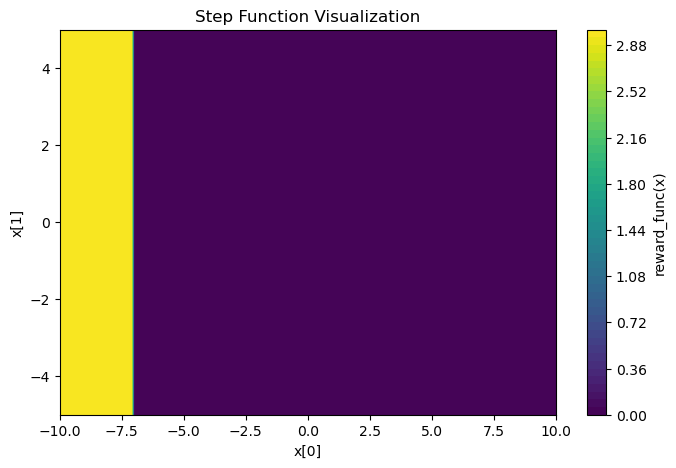

In [36]:
B = 3
k = 2
def reward_func(x):
    """
    Smoothed step function for 2D input.
    Returns values close to B when x[..., 0] < -7, and close to 0 otherwise.
    Smoothly transitions between B and 0 around x[..., 0] = -7.
    """
    x0 = np.asarray(x)[..., 0]
    # Sigmoid centered at -7, scale for smoothness
    return B / (1 + np.exp(k * (x0 + 8)))

def reward_func_hard(x):
    """
    Hard step function for 2D input.
    Returns B when x[..., 0] < -7, and 0 otherwise.
    """
    x0 = np.asarray(x)[..., 0]
    return np.where(x0 < -7, B, 0)

L_r = B*k/4

# Plot the function on a 2D plane
x1 = np.linspace(-10, 10, 200)
x2 = np.linspace(-5, 5, 200)
X1, X2 = np.meshgrid(x1, x2)
Z = reward_func_hard(np.stack([X1, X2], axis=-1))

plt.figure(figsize=(8, 5))
plt.contourf(X1, X2, Z, levels=50, cmap='viridis')
plt.colorbar(label='reward_func(x)')
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.title('Step Function Visualization')
plt.show()


In [65]:
n = T = 20
t_vals = np.arange(1, n+1)
c, delta = 4, 0.02
inner = delta * (1 + c * np.log(n) / n)**t_vals
alpha_t = 1 - (c * np.log(n) / n) * np.minimum(inner, 1)
alpha_t[0] = 1 - delta
d = 2

In [38]:
from mixture_lower import Mixture
from guided_models import Diffusion
# Monte Carlo parameters
num_trials =1 # Number of Monte Carlo trials
num_training_trials = 50_000
# First loop: Train and store val_ensembles and reward_ests
val_ensembles = []
reward_ests = []



# Initialize random mixture means in [-1,1]^d
mu_0 = np.array([[5, 0], [-5, 0]])

# Shared covariance matrix
var_0 = np.eye(d)

# Mixture weights (normalized)
pi_0 = np.array([0.95, 0.05])
pi_0 /= np.sum(pi_0)

# Initialize diffusion process
dist0 = Mixture(mu_0, var_0, pi_0)
diffusion = Diffusion(dist0, alpha_t, S = num_training_trials)

X = diffusion.calc_samples()




Reverse Diffusion Progress: 100%|██████████| 19/19 [00:25<00:00,  1.34s/it]


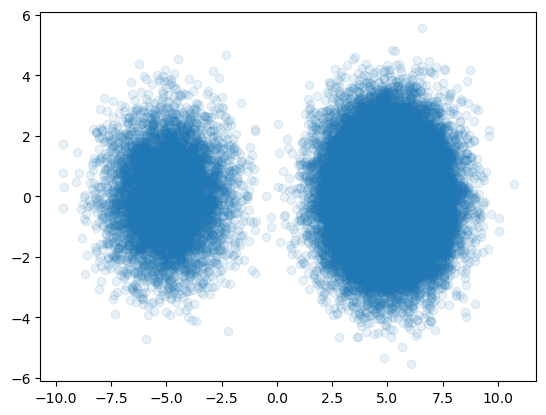

In [39]:
plt.scatter(X[:, -1, 0], X[:, -1, 1], alpha=0.1)

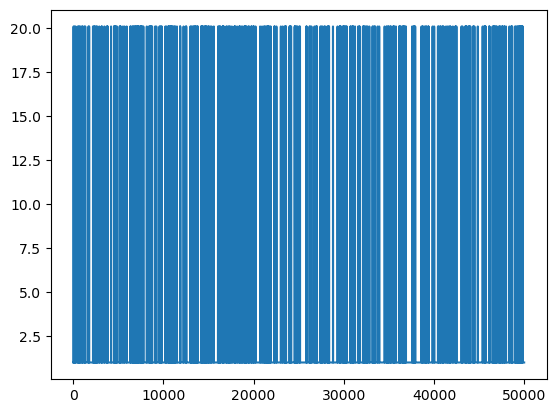

In [40]:
expr = np.exp(reward_func_hard(X[:, -1, :]))
plt.plot(expr)

In [41]:
from value_estimator import ValueEstimate
val_ensemble = ValueEstimate(X, expr, [128, 500, 500])
val_ensemble.train()


Building ValueEstimate...
[Epoch 01] avg MSE: 2.6122
[Epoch 02] avg MSE: 2.4746
[Epoch 03] avg MSE: 2.2995
[Epoch 04] avg MSE: 2.2180
[Epoch 05] avg MSE: 2.1955
[Epoch 06] avg MSE: 2.1838
[Epoch 07] avg MSE: 2.1788
[Epoch 08] avg MSE: 2.1651
[Epoch 09] avg MSE: 2.1619
[Epoch 10] avg MSE: 2.1555
[Epoch 11] avg MSE: 2.1484
[Epoch 12] avg MSE: 2.1458
[Epoch 13] avg MSE: 2.1421
[Epoch 14] avg MSE: 2.1386
[Epoch 15] avg MSE: 2.1321
[Epoch 16] avg MSE: 2.1300
[Epoch 17] avg MSE: 2.1272
[Epoch 18] avg MSE: 2.1230
[Epoch 19] avg MSE: 2.1188
[Epoch 20] avg MSE: 2.1143


2.1142564554439782

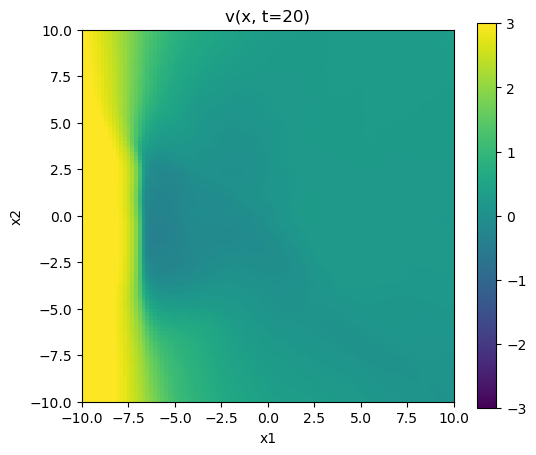

In [43]:
from matplotlib import animation

# Create a grid of x values
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
xx1, xx2 = np.meshgrid(x1, x2)
grid_x = np.stack([xx1.ravel(), xx2.ravel()], axis=1)

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(np.zeros_like(xx1), extent=[-10, 10, -10, 10], origin='lower', vmin=-B, vmax=B)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('v(x, t) over time')
cb = fig.colorbar(cax)

t_vals = list(range(1, n + 1))

def animate(t_idx):
    t = t_vals[t_idx]
    t_arr = np.full((grid_x.shape[0],), t)
    v = val_ensemble.predict_under_log(grid_x, t_arr)
    v = np.squeeze(v)
    v_img = v.reshape(xx1.shape)
    cax.set_data(v_img)
    ax.set_title(f'v(x, t={t})')
    return [cax]

ani = animation.FuncAnimation(fig, animate, frames=len(t_vals), interval=100, blit=True)
ani.save('v_under_log_over_time_differentiable.gif', writer='pillow', fps=2)
plt.show()

In [44]:
from mixture_lower import Mixture
from guided_models import Diffusion
from mixture_guidance import MixtureSpecificGuidance
n = T = 50
t_vals = np.arange(1, n+1)
c, delta = 4, 0.02
inner = delta * (1 + c * np.log(n) / n)**t_vals
alpha_t = 1 - (c * np.log(n) / n) * np.minimum(inner, 1)
alpha_t[0] = 1 - delta

mu_0 = np.array([[5, 0], [-5, 0]])
d = 2
num_training_trials = 10
# Shared covariance matrix
var_0 = np.eye(d)

# Mixture weights (normalized)
pi_0  = np.array([0.95, 0.05])
pi_0 /= np.sum(pi_0)
dist0 = Mixture(mu_0, var_0, pi_0)


In [53]:
from mixture_guidance import MixtureSpecificGuidance
diffusion_msg = MixtureSpecificGuidance(dist0, alpha_t, reward_func_hard, L_r = L_r, value_fn=lambda t, x: (np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B))),   S = 5000, delta = 0.01, use_trace = False)
X_msg = diffusion_msg.calc_samples()

yo?


Mixture reverse: 100%|██████████| 49/49 [01:08<00:00,  1.40s/it]


In [54]:
diffusion_msg.num_steps

1345591

In [56]:
from guided_models import GuidedDiffusion
guided_per = GuidedDiffusion(dist0, alpha_t, lambda x, t: np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B)), upper_bound=B, temperature=1, S=5000)
X_per = guided_per.calc_samples()   

Reverse Diffusion Progress: 100%|██████████| 49/49 [03:47<00:00,  4.64s/it]


In [ ]:
from guided_models import LastStepDiffusion
guided_true = LastStepDiffusion(dist0, alpha_t, lambda x: np.log(np.clip(reward_func_hard(x), np.e**(-B), np.e**B)), upper_bound=B, S=5000)
X_guided_true = guided_true.calc_samples()

Generating Trajectories: 5009it [1:36:06,  1.15s/it]                            


In [58]:
def func(x, val_ensemble):
    x = np.expand_dims(x, axis=0)
    t_arr = np.array([T - 1])
    return np.log(val_ensemble.predict(x, t_arr))

guided_last = LastStepDiffusion(dist0, alpha_t, lambda x: func(np.array(x), val_ensemble), upper_bound=B, S=5000)
X_guided_last = guided_last.calc_samples()

NameError: name 'LastStepDiffusion' is not defined

In [205]:
diffusion.num_steps

516009

In [ ]:
guided_true.num_steps

82807206

In [197]:
guided_last.num_steps

1895068

In [198]:
guided_per.num_steps

1681669

In [181]:
diffusion = Diffusion(dist0, alpha_t, S = 5000)
X_unguided = diffusion.calc_samples()

Reverse Diffusion Progress: 100%|██████████| 19/19 [00:03<00:00,  5.92it/s]


In [59]:
X_per.shape

(5000, 50, 2)

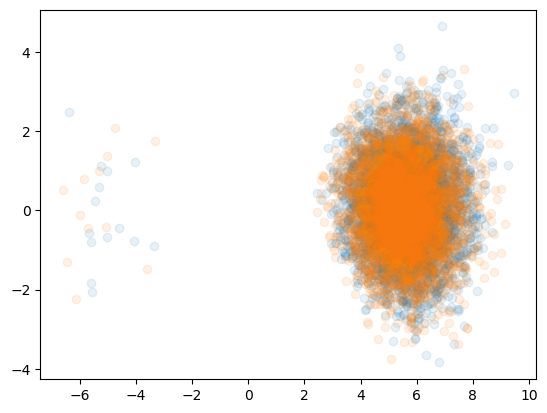

In [61]:

plt.scatter(X_msg[:, -1, 0], X_msg[:, -1, 1], alpha=0.1)
plt.scatter(X_per[:, -1, 0], X_per[:, -1, 1], alpha=0.1)
# plt.scatter(X_unguided[:,-1, 0], X_unguided[:, -1, 1], color = 'green', alpha = 0.2)
# plt.scatter(X_unguided[:, -1, 0], X_unguided[:, -1, 1], alpha = 1)
# plt.scatter(X_guided_last[:, -1, 0], X_guided_last[:, -1,1], color='blue', alpha = 0.2)
# plt.scatter(X_guided_true[:, -1, 0], X_guided_true[:, -1,1], color='orange', alpha = 0.2)

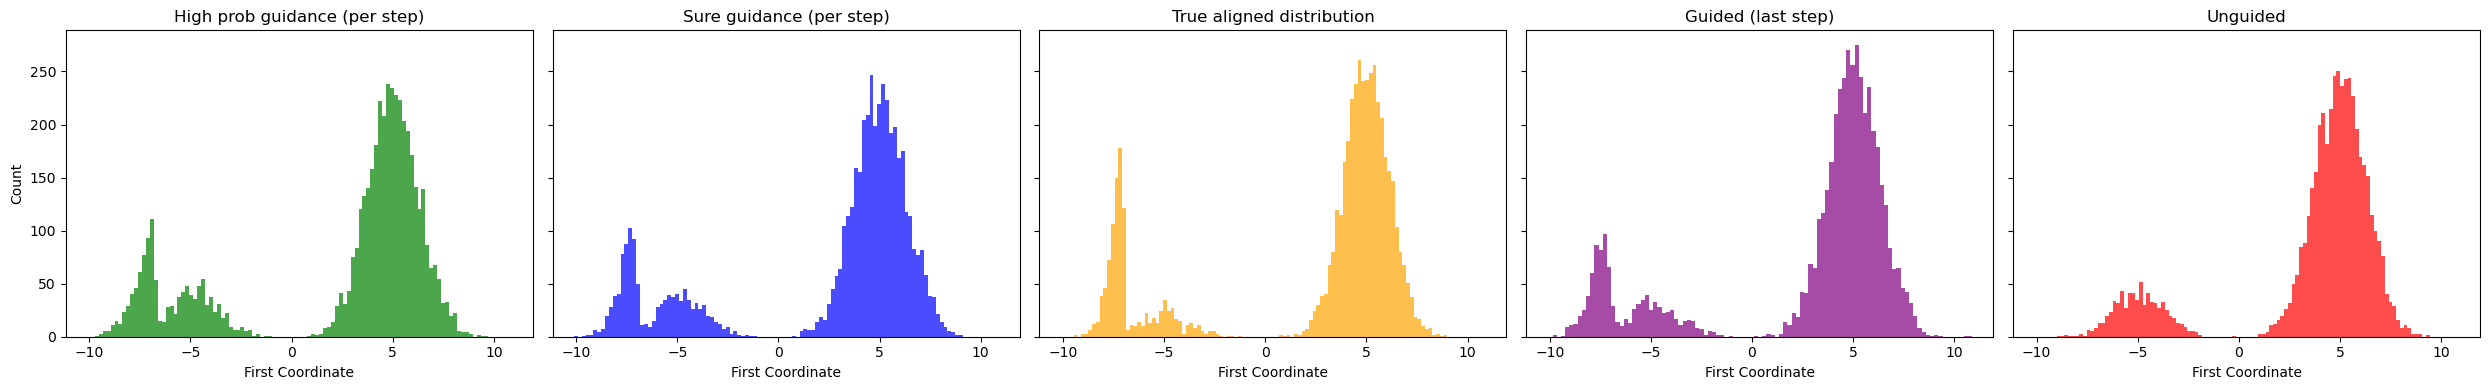

In [200]:
fig, axs = plt.subplots(1, 5, figsize=(25, 4), sharex=True, sharey=True)

axs[0].hist(X[:, -1, 0], bins=100, alpha=0.7, color='green')
axs[0].set_title('High prob guidance (per step)')
axs[0].set_xlabel('First Coordinate')
axs[0].set_ylabel('Count')

axs[1].hist(X_per[:, -1, 0], bins=100, alpha=0.7, color='blue')
axs[1].set_title('Sure guidance (per step)')
axs[1].set_xlabel('First Coordinate')

axs[2].hist(X_guided_true[:, -1, 0], bins=100, alpha=0.7, color='orange')
axs[2].set_title('True aligned distribution')
axs[2].set_xlabel('First Coordinate')

axs[3].hist(X_guided_last[:, -1, 0], bins=100, alpha=0.7, color='purple')
axs[3].set_title('Guided (last step)')
axs[3].set_xlabel('First Coordinate')

axs[4].hist(X_unguided[:, -1, 0], bins=100, alpha=0.7, color='red')
axs[4].set_title('Unguided')
axs[4].set_xlabel('First Coordinate')

plt.tight_layout()
plt.show()

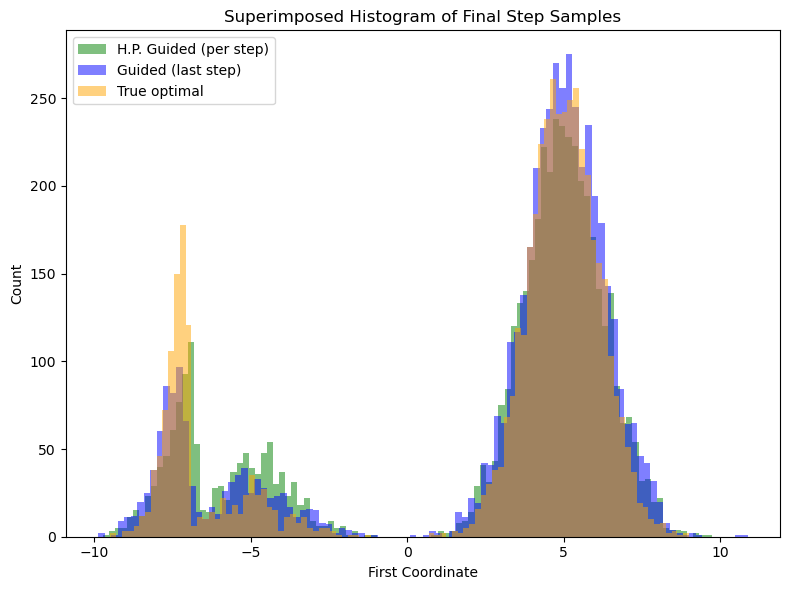

In [202]:
plt.figure(figsize=(8, 6))
plt.hist(X[:, -1, 0], bins=100, alpha=0.5, color='green', label='H.P. Guided (per step)')
plt.hist(X_guided_last[:, -1, 0], bins=100, alpha=0.5, color='blue', label='Guided (last step)')
plt.hist(X_guided_true[:, -1, 0], bins=100, alpha=0.5, color='orange', label='True optimal')
plt.xlabel('First Coordinate')
plt.ylabel('Count')
plt.title('Superimposed Histogram of Final Step Samples')
plt.legend()
plt.tight_layout()
plt.show()

In [186]:
mesh_density = 30  # Change this value to control mesh density

# Define bin edges based on the range of all samples
bins_x = np.linspace(mins[0], maxs[0], mesh_density)
bins_y = np.linspace(mins[1], maxs[1], mesh_density)

X_final = X[:, -1, :]
X_guided_true_final = X_guided_true[:, -1, :]
# Compute 2D histograms for both sets of samples
hist_empirical, _, _ = np.histogram2d(X_final[:, 0], X_final[:, 1], bins=[bins_x, bins_y], density=True)
hist_guided_true, _, _ = np.histogram2d(X_guided_true_final[:, 0], X_guided_true_final[:, 1], bins=[bins_x, bins_y], density=True)

# Normalize histograms to sum to 1 (probability distributions)
hist_empirical /= hist_empirical.sum()
hist_guided_true /= hist_guided_true.sum()

# Compute TV distance
tv_distance_binned = 0.5 * np.sum(np.abs(hist_empirical - hist_guided_true))
print(f"Total Variation distance (binned): {tv_distance_binned:.4f}")


NameError: name 'mins' is not defined

In [ ]:
mesh_density = 30  # Change this value to control mesh density

# Define bin edges based on the range of all samples
bins_x = np.linspace(mins[0], maxs[0], mesh_density)
bins_y = np.linspace(mins[1], maxs[1], mesh_density)

X_final = X_guided_last[:, -1, :]
X_guided_true_final = X_guided_true[:, -1, :]
# Compute 2D histograms for both sets of samples
hist_empirical, _, _ = np.histogram2d(X_final[:, 0], X_final[:, 1], bins=[bins_x, bins_y], density=True)
hist_guided_true, _, _ = np.histogram2d(X_guided_true_final[:, 0], X_guided_true_final[:, 1], bins=[bins_x, bins_y], density=True)

# Normalize histograms to sum to 1 (probability distributions)
hist_empirical /= hist_empirical.sum()
hist_guided_true /= hist_guided_true.sum()

# Compute TV distance
tv_distance_binned = 0.5 * np.sum(np.abs(hist_empirical - hist_guided_true))
print(f"Total Variation distance (binned): {tv_distance_binned:.4f}")


In [195]:
from tv_estimator import tv_bounds_classifier, save_samples

# X_star, X_hat are shape (n, d)
report = tv_bounds_classifier(X[:, -1, :], X_per[:, -1, :])
report


{'n_star': 5000,
 'n_hat': 5000,
 'd': 2,
 'test_error': 0.5126666666666666,
 'tv_lower_bound': 0.0,
 'tv_plugin': 0.020363952271646567,
 'kl_star_hat': 0.0006262159900990878,
 'kl_hat_star': 0.0008855768193634006,
 'tv_upper_bound': 0.017694857870283784}

In [196]:
delta

0.02

In [192]:
from tv_estimator import tv_bounds_classifier, save_samples

# X_star, X_hat are shape (n, d)
report = tv_bounds_classifier(X[:, -1, :], X_guided_true[:, -1, :])
report


{'n_star': 5000,
 'n_hat': 5000,
 'd': 2,
 'test_error': 0.4906666666666667,
 'tv_lower_bound': 0.01866666666666661,
 'tv_plugin': 0.010908330460868544,
 'kl_star_hat': -0.000202814865842978,
 'kl_hat_star': 0.0009223902834916654,
 'tv_upper_bound': 0.0}

In [193]:
from tv_estimator import tv_bounds_classifier, save_samples

# X_star, X_hat are shape (n, d)
report = tv_bounds_classifier(X_unguided[:, -1, :], X_guided_true[:, -1, :])
report


{'n_star': 5000,
 'n_hat': 5000,
 'd': 2,
 'test_error': 0.481,
 'tv_lower_bound': 0.038000000000000034,
 'tv_plugin': 0.10057763867583126,
 'kl_star_hat': 0.03507287948154843,
 'kl_hat_star': 0.034542547514530376,
 'tv_upper_bound': 0.13142021822103778}